In [78]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from fastai2.vision.all import load_image, get_image_files, show_image, \
    show_images
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from htools import *
from img_wang.torch_utils import *

In [80]:
cd_root()
gpu_setup()

Current directory: /Users/hmamin/img_wang
Setting seeds for reproducible training.


/Users/hmamin/img_wang/lib/img_wang/torch_utils.py:84: UserWarning: Cuda not available.
  if not torch.cuda.is_available(): warnings.warn('Cuda not available.')
/Users/hmamin/img_wang/lib/img_wang/torch_utils.py:85: UserWarning: Incendio device is not cuda.
  if DEVICE.type != 'cuda': warnings.warn('Incendio device is not cuda.')


In [135]:
class AlbumentationsDataset(Dataset):

    @valuecheck
    def __init__(self, dir_=None, paths=(), shape=(128, 128), pct_pos=.5,
                 tfm='ChannelShuffle', **tfm_kwargs):
        """
        dir_: str or Path
            Name of directory containing image files.
        paths: Iterable[str or Path]
            Alternately, user can provide a list of image paths instead of a
            directory name. Exactly one of these should be not None.
        shape: tuple[int]
            Shape to resize images to. Just use defaults always (the image wang
            challenge was designed with specific shapes in mind to allow for
            direct comparisons).
        pct_pos: float
            Percent of generated samples that will be positives (patch comes
            from the same image as the source image).
        tfm: str
            Name of Albumentations transform to apply with probability `pct_pos`.
            Semi-promising tfm choices: ChannelShuffle, ElasticTransform
        tfm_kwargs: any
            Additional kwargs to pass to the selected Albumentations transform.
        """
        if not dir_ and not paths:
            raise ValueError('One of dir_ or paths should be non-null.')

        self.paths = paths or get_image_files(dir_)
        self.shape = shape
        self.pct_pos = pct_pos
        self.load_img = load_image
        self.tfm = getattr(A, tfm)(always_apply=True)
        self.tfm_pipeline = A.Compose([A.Resize(*shape),
                                       ToTensorV2()])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        """
        1 if patch is from the original image, 0 otherwise.
        """
        x = np.array(self.load_img(self.paths[i]))
        if len(x.shape) == 2: x = np.repeat(x[..., None], 3, axis=2)
        y = 0
        if np.random.uniform() < self.pct_pos:
            x = self.tfm(image=x)['image']
            y = 1
        return self.tfm_pipeline(image=x)['image']/255.0, y

In [82]:
def show_batches(dl, n=3, **show_kwargs):
    for i, (xb, yb) in enumerate(dl):
        show_images([x for x in xb.cpu()],
                    titles=yb.cpu().numpy().tolist(),
                    **show_kwargs)
        if i >= n-1: break

In [83]:
paths = get_image_files('data/imagewang-160/unsup')[:128]

In [84]:
ds = AlbumentationsDataset(paths=paths)
dl = DataLoader(ds, batch_size=4, shuffle=False)

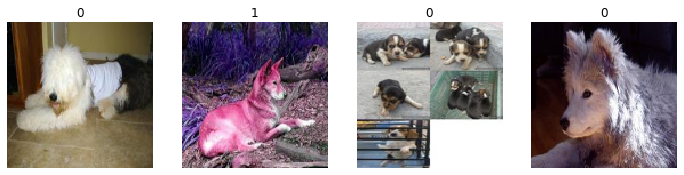

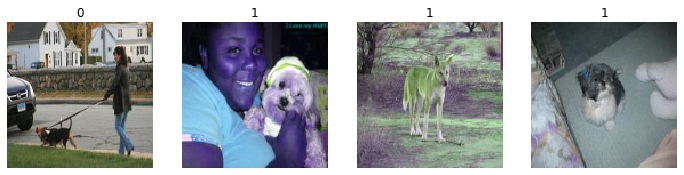

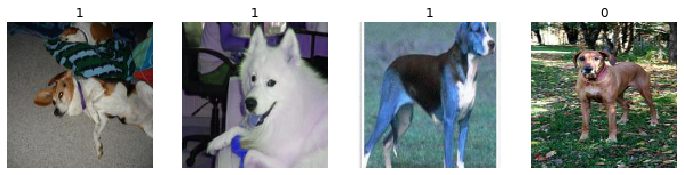

In [15]:
show_batches(dl)

In [17]:
ds = AlbumentationsDataset(paths=paths[:32], tfm='CLAHE')
dl = DataLoader(ds, batch_size=4, shuffle=False)

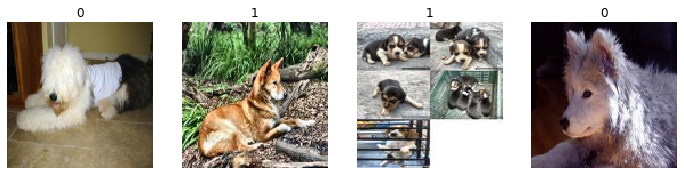

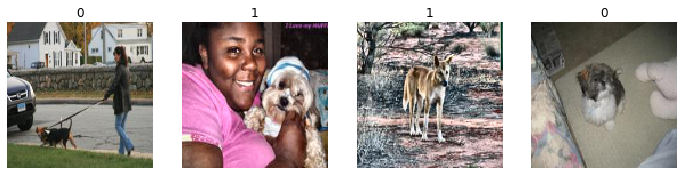

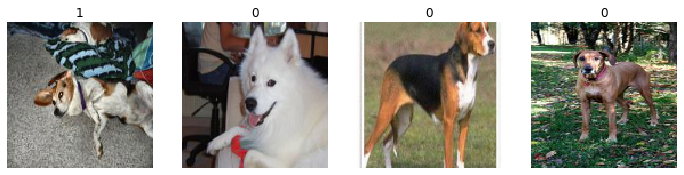

In [18]:
show_batches(dl)

In [21]:
ds = AlbumentationsDataset(paths=paths[:32], tfm='ElasticTransform')
dl = DataLoader(ds, batch_size=4, shuffle=False)

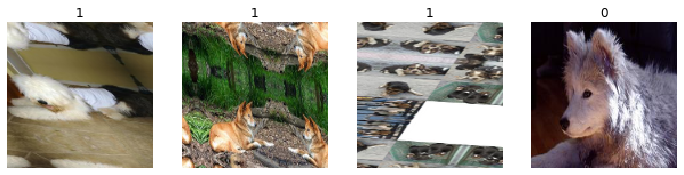

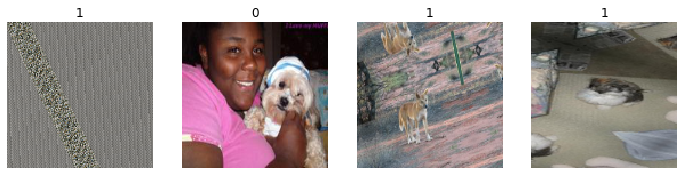

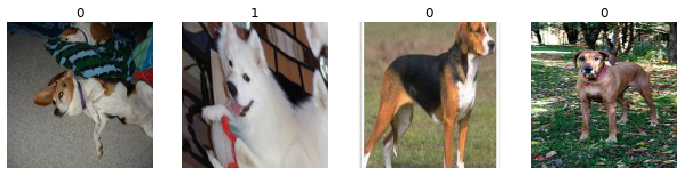

In [22]:
show_batches(dl)

In [23]:
ds = AlbumentationsDataset(paths=paths[:32], tfm='GridDistortion')
dl = DataLoader(ds, batch_size=4, shuffle=False)

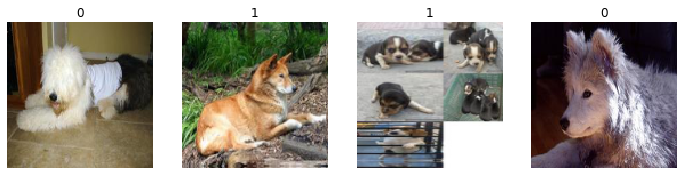

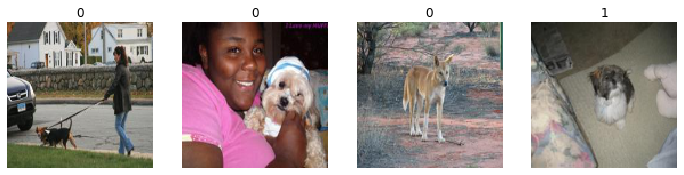

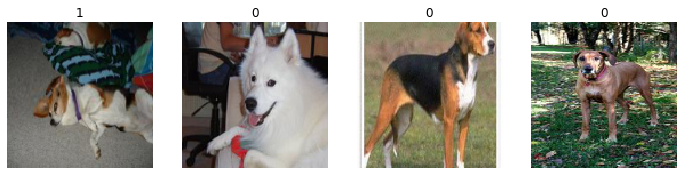

In [24]:
show_batches(dl)

In [91]:
x = load_image(ds.paths[4])

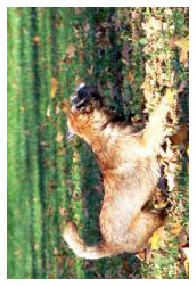

In [134]:
show_image(A.RandomRotate90(p=1.0)(image=np.array(x), factor=1)['image'])

In [136]:
ds = AlbumentationsDataset(paths=paths[:32], tfm='RandomRotate90', factor=1)
dl = DataLoader(ds, batch_size=4, shuffle=False)

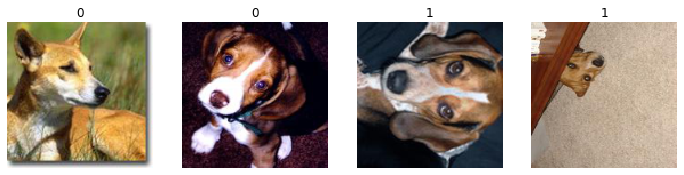

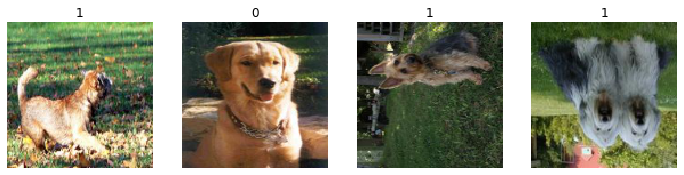

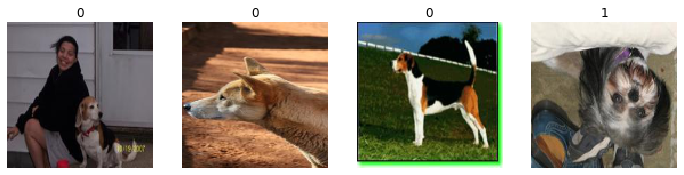

In [137]:
show_batches(dl)